In [250]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time 
import pandas as pd
from torch import nn
import collections

import progressbar
from progressbar import FormatLabel, Percentage, Bar, ETA


from data_loader import DataLoader
#import viewer functions
from dataViewer import plotTraj, animatePreview, animateLoc, animateTraj

import hdf5_utils as h
from simulation import Agent, Engine
import h5py
import os


%matplotlib notebook
%load_ext autoreload
%autoreload 

plt.style.use("plotstyle.mplstyle")

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
def batch(arr1, arr2, n):
    """Yield successive n-sized chunks from l."""
    size = len(arr1)
    for i in range(0, size, n):
        yield arr1[i:min(i + n, size)], arr2[i:min(i + n, size)]
        
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
        

In [219]:


#hidden_layer = [32, 32, 64, 128, 128, 40]

#hidden_layer = [ 128, 128, 40, 32, 32, 64,]
#hidden_layer = [ 50, 30, 10, 20, 30, 30,]
#hidden_layer = [28 ,20, 10, 10]




load_traindata = True

dset = {'neighbors':7,
        'ret_vel':False,
        'nn_vel': False,
        'truth_with_vel': False,
        'shuffle':True,
        'mode': "wrap",
        'step_nr':1,
        'downsample':8,
        'fps':16,
        'name':  "ao-360-400_combine_f0"#"ug-100-045", #"ao-360-400_combine"
       }




param = {'input_s': 2+2*dset['ret_vel']  + dset['neighbors']*(2+2*dset['nn_vel']), #(number_nei+1)*4,
         'hidden_s': [ 50,20,50],
         'output_s': 2+dset['truth_with_vel']*2,
         'epochs':15,
         'batch_size':10,
         'lr':1e-3,
         'decay':0.1,
         'decay_step':5,
         #'dtype':torch.float,
         'device':torch.device("cpu"),
         'dataset':dset,
        }

#FPS = 16
#BG = "Datasets/UG/ug.png"

#PATH_1 = "Datasets/UG/UG-roh_nachkorrigiert/ug-100-007.txt"


PATH = "data/CSV/"
#PATH = "Datasets/UG/UG-roh_nachkorrigiert/"
PATH2 = "data/HD5/"


In [220]:

ds = DataLoader(PATH + dset['name'] + ".csv")

ds.load()

print("Persons: ", ds.data.p.max())
print("Frame maximum :", ds.data.f.max() )


sufix = "_nn{}_s{}_vr{}_m{}_vi{}_st{}_d{}".format(dset['neighbors'],
                                 dset['shuffle'],
                                 dset['truth_with_vel'],
                                 dset['mode'],
                                 dset['ret_vel']+dset['nn_vel'], 
                                 dset['step_nr'],
                                 dset['downsample'])


f_name = PATH2+param['dataset']['name']+sufix+'.h5'

if os.path.isfile(f_name) and load_traindata:

    train, val, test, param['dataset'] = hd.load_trainingdata(f_name)
    print("Training data has been loaded")

else:
    #f_x = ds.flip_x

    augmentation = [] #[f_x]
    train, val, test = ds.get_train_data(dset['neighbors'], 
                                         step_nr=dset['step_nr'],
                                         downsample=dset['downsample'],
                                         augmentation=augmentation,
                                         ret_vel=dset['ret_vel'],
                                         nn_vel=dset['nn_vel'],
                                         shuffle=dset['shuffle'],
                                         truth_with_vel=dset['truth_with_vel'],
                                         mode=dset['mode'])
    dset['date'] = time.ctime()
    dset['creator'] = 'riesemichi'
    dset['augmentation'] = str(augmentation)
    param['dataset'] = dset
    
    hd.save_trainingdata(f_name, param, train, val, test)
    print("Training data saved to : {}".format(PATH2+f_name+sufix+'.h5'))

Persons:  350
Frame maximum : 821
Training data has been loaded


C:\Users\maeic\polybox\HS20\GESS\AIPD\michaelneck2\hdf5_utils.py:131: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  train = (database.get('train/input').value, database.get('train/truth').value )
C:\Users\maeic\polybox\HS20\GESS\AIPD\michaelneck2\hdf5_utils.py:132: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  val = (database.get('val/input').value, database.get('val/truth').value )
C:\Users\maeic\polybox\HS20\GESS\AIPD\michaelneck2\hdf5_utils.py:133: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  test = (database.get('test/input').value, database.get('test/truth').value )


In [221]:
hd.print_stats(PATH2+param['dataset']['name']+sufix+'.h5')

File: data/HD5/ao-360-400_combine_f0_nn7_sTrue_vrFalse_mwrap_vi0_st1_d8.h5/
|     Size: 6.35MB
|     @augmentation: []
|     @creator: riesemichi
|     @date: Tue Nov 24 21:23:54 2020
|     @downsample: 8
|     @fps: 16
|     @mode: wrap
|     @name: ao-360-400_combine_f0
|     @neighbors: 7
|     @nn_vel: False
|     @ret_vel: False
|     @shuffle: True
|     @step_nr: 1
|     @truth_with_vel: False
|
|Group: test 
|     |-----Dataset: input           - Shape: (18393, 16) float32
|     |-----Dataset: truth           - Shape: (18393, 2) float32
|
|Group: train 
|     |-----Dataset: input           - Shape: (55179, 16) float32
|     |-----Dataset: truth           - Shape: (55179, 2) float32
|
|Group: val 
|     |-----Dataset: input           - Shape: (18394, 16) float32
|     |-----Dataset: truth           - Shape: (18394, 2) float32


# Format training data as tensors

In [222]:
t_input, t_truth = train
v_input, v_truth = val
test_input, test_truth = test

t_i = torch.from_numpy(t_input).to(param['device'])
t_t = torch.from_numpy(t_truth).to(param['device'])

v_i = torch.from_numpy(v_input).to(param['device'])
v_t = torch.from_numpy(v_truth).to(param['device'])

test_i = torch.from_numpy(test_input).to(param['device'])
test_t = torch.from_numpy(test_truth).to(param['device'])




# Define Model

In [224]:


# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc_in = nn.Linear(input_size, hidden_size[0]) 
        
        #self.fc_hidden = []
        #for i in range(len(hidden_size)-1):
        self.fc_hidden_1 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc_hidden_2 = nn.Linear(hidden_size[1], hidden_size[2])
        #self.fc_hidden_3 = nn.Linear(hidden_size[2], hidden_size[3])
        
        #self.fc_hidden_4 = nn.Linear(hidden_size[3], hidden_size[4])
        #self.fc_hidden_5 = nn.Linear(hidden_size[4], hidden_size[5])

        
        self.fc_out = nn.Linear(hidden_size[-1], output_size)
        self.relu = nn.ReLU()
        #self.drop = nn.Dropout(0.1)
    
    def forward(self, x):
     
        out = self.relu(self.fc_in(x))
        
        #for i in range(len(self.fc_hidden)):
        #    out = self.relu(self.fc_hidden[i](out))
        
        out = self.relu(self.fc_hidden_1(out))
        out = self.relu(self.fc_hidden_2(out))
        #out = self.relu(self.fc_hidden_3(out))
        #out = self.relu(self.fc_hidden_4(out))
        #out = self.drop(out)
        #out = self.relu(self.fc_hidden_5(out))
        
        
        out = self.fc_out(out)
        return out


model = NeuralNet(param['input_s'], param['hidden_s'], param['output_s']).to(param['device'])


In [225]:
#choose loss function - can be played around with
loss_fn = torch.nn.MSELoss(reduction='mean')


optimizer = torch.optim.Adam(model.parameters(), lr=param['lr'])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=param['decay_step'], gamma=param['decay'])


In [226]:

d_len = t_i.shape[0]


#pbar = progressbar.ProgressBar(max_value=param['epochs'])
widgets = [FormatLabel(''), ' ', Percentage(), ' ', Bar(), ' ', ETA()]
pbar = progressbar.ProgressBar(widgets=widgets, maxval=param['epochs']*d_len)
pbar.start()

training_loss = []
validation_loss = [0.0]

for t in range(param['epochs']):
    
    # Train on Batches
    
    p = np.random.permutation(len(t_i))
    t_i = t_i[p]
    t_t = t_t[p]
    
    for  y, (t_i_b, t_t_b) in  enumerate(batch(t_i, t_t, param['batch_size'])):
        y_pred = model(t_i_b)
       
        loss = loss_fn(y_pred, t_t_b)

        optimizer.zero_grad()
       
        loss.backward()

        optimizer.step()
        
        widgets[0] = FormatLabel('loss(t/v) : {:.4} / {:.4} | lr={:.4}'.format(loss.item(),
                                                                            validation_loss[-1],
                                                                            optimizer.param_groups[0]['lr']))
        pbar.update(t*d_len+y*param['batch_size'])
        
        if y%10==9:
            training_loss += [loss.cpu().detach().numpy()]
    
    # Test on validation
    
    loss = []
    with torch.no_grad():
        for v_i_b, v_t_b in batch(v_i, v_t, param['batch_size']):
            y_pred = model(v_i_b)
            loss += [loss_fn(y_pred, v_t_b).cpu().detach().numpy()]
            pbar.update()
    validation_loss.append( np.array(loss).mean() )
    
    scheduler.step()
        

pbar.finish()




 100% |########################################################| Time:  0:02:08


<IPython.core.display.Javascript object>


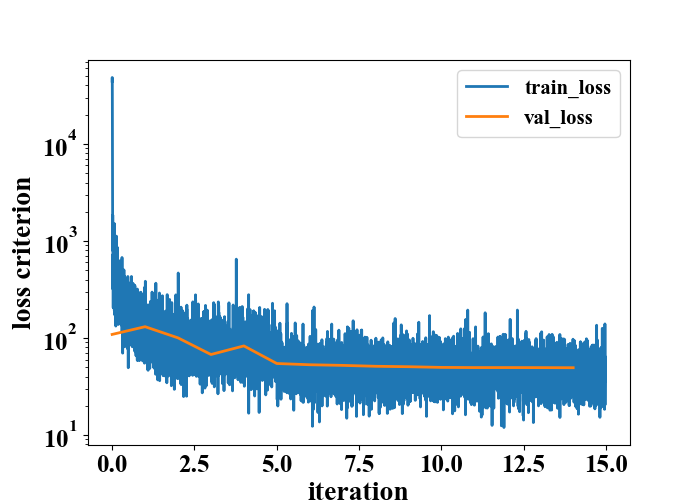

15
8265


In [227]:

train_loss = np.array(training_loss)
val_loss = np.array(validation_loss[1:])

plt.figure()
plt.semilogy(np.arange(len(train_loss))*10*param['batch_size']/d_len, train_loss, label="train_loss")
plt.semilogy(np.arange(len(val_loss)), val_loss, label="val_loss" )
plt.xlabel("iteration")
plt.ylabel("loss criterion")
plt.legend()
plt.show()
print(len(val_loss))
print(len(train_loss))

In [205]:
model.eval()



NeuralNet(
  (fc_in): Linear(in_features=28, out_features=32, bias=True)
  (fc_hidden_1): Linear(in_features=32, out_features=32, bias=True)
  (fc_hidden_2): Linear(in_features=32, out_features=64, bias=True)
  (fc_hidden_3): Linear(in_features=64, out_features=128, bias=True)
  (fc_hidden_4): Linear(in_features=128, out_features=128, bias=True)
  (fc_hidden_5): Linear(in_features=128, out_features=40, bias=True)
  (fc_out): Linear(in_features=40, out_features=4, bias=True)
  (relu): ReLU()
)

# Check on test set

100% (18393 of 18393) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


<IPython.core.display.Javascript object>


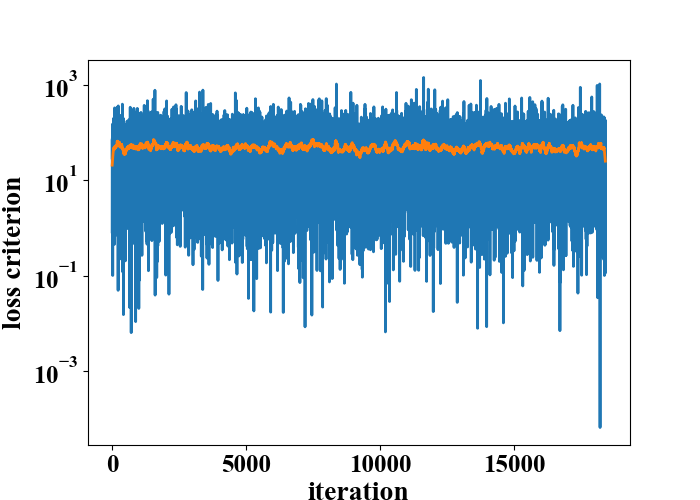

In [228]:

test_dat = []

pbar = progressbar.ProgressBar(maxval=len(test_i))
pbar.start()

i = 0

with torch.no_grad():
    for (ti, tt) in zip(test_i, test_t):
        pred = model(ti)
        loss = loss_fn(pred, tt)
        test_dat.append(loss.cpu().detach().numpy())
     
        if i%10:
            pbar.update(i)
        
        i += 1
        
    pbar.finish()
    
test_dat = np.array(test_dat)

plt.figure()
plt.semilogy(np.arange(len(test_dat)), test_dat)
plt.semilogy(np.arange(len(test_dat)), smooth(test_dat, 100))
plt.xlabel("iteration")
plt.ylabel("loss criterion")
plt.show()

# Save/ Load model

In [229]:
PATH_M = "data/model/"
#name = "model_UG_downsample_good_"
#name = "model_UG_downsample_good_"
name = "mneck2"

suffix_m = "_nn{}_vel{}{}_{}_s{}_{}_{}_e{}_lr{}".format(param['dataset']['neighbors'],
                                                         param['dataset']['ret_vel'],param['dataset']['nn_vel'],param['dataset']['truth_with_vel'],
                                                         param['input_s'],param['hidden_s'],param['output_s'],
                                                         param['epochs'],
                                                         param['lr'],
                                                        )


#f_name = PATH_M+name+"sweep_vel.h5"
f_name = PATH_M+name+suffix_m+".h5"    

#hd.print_stats(f_name)
suffix_m

'_nn7_velFalseFalse_False_s16_[50, 20, 50]_2_e15_lr0.001'

In [230]:

param['msg'] = "network for bottleneck - michaelneck "


hd.save_torch(model, optimizer, f_name, param, prefix="", scan=False) # prefix for scans

single


In [194]:
model , param = hd.load_torch(f_name, NeuralNet, prefix="")
model.eval()

{'hidden_s': array([128, 128,  40,  32,  32,  64]), 'input_s': 16, 'layers': array(['fc_in.weight', 'fc_in.bias', 'fc_hidden_1.weight',
       'fc_hidden_1.bias', 'fc_hidden_2.weight', 'fc_hidden_2.bias',
       'fc_hidden_3.weight', 'fc_hidden_3.bias', 'fc_hidden_4.weight',
       'fc_hidden_4.bias', 'fc_hidden_5.weight', 'fc_hidden_5.bias',
       'fc_out.weight', 'fc_out.bias'], dtype=object), 'output_s': 2}


NeuralNet(
  (fc_in): Linear(in_features=16, out_features=128, bias=True)
  (fc_hidden_1): Linear(in_features=128, out_features=128, bias=True)
  (fc_hidden_2): Linear(in_features=128, out_features=40, bias=True)
  (fc_hidden_3): Linear(in_features=40, out_features=32, bias=True)
  (fc_hidden_4): Linear(in_features=32, out_features=32, bias=True)
  (fc_hidden_5): Linear(in_features=32, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
)

In [195]:
hd.print_stats(f_name)

File: data/model/mneck_nn7_velFalseFalse_False_s16_[128, 128, 40, 32, 32, 64]_2_e15_lr0.001.h5/
|     Size: 161.38KB
|     @batch_size: 10
|     @creator: zehndiii
|     @date: Wed Nov 25 13:20:25 2020
|     @decay: 0.1
|     @decay_step: 5
|     @device: cpu
|     @epochs: 15
|     @lr: 0.001
|     @mode: single_model
|     @msg: network for bottleneck - michaelneck 
|
|Group: dataset 
|     @augmentation: []
|     @creator: riesemichi
|     @date: Tue Nov 24 21:23:54 2020
|     @downsample: 8
|     @fps: 16
|     @mode: wrap
|     @name: ao-360-400_combine_f0
|     @neighbors: 7
|     @nn_vel: False
|     @ret_vel: False
|     @shuffle: True
|     @step_nr: 1
|     @truth_with_vel: False
|
|Group: model 
|     @hidden_s: [128 128  40  32  32  64]
|     @input_s: 16
|     @layers: ['fc_in.weight' 'fc_in.bias' 'fc_hidden_1.weight' 'fc_hidden_1.bias'
 'fc_hidden_2.weight' 'fc_hidden_2.bias' 'fc_hidden_3.weight'
 'fc_hidden_3.bias' 'fc_hidden_4.weight' 'fc_hidden_4.bias'
 'fc_hidden_5.we

['hallo']

# Single agent

In [52]:



test_person = 22

da = DataLoader(None)


da.copy(ds)
# crop the standing phase
#da.data = da.data[ da.data['f']>100]

frames_o, pos_vel_o = da.person(test_person, )
#frames, pos_vel = da.grab_roi(frames_o, pos_vel_o, x_pad=50)

da.remove_person(test_person)

print(frames_o[0], frames_o[-1])

agent = Agent(model,
              FPS=param['dataset']['fps']/param['dataset']['downsample'],
              pos_vel_0=pos_vel_o[0],
              frame_0=frames_o[0],
              truth_with_vel=param['dataset']['truth_with_vel'],
              device=param['device'],
              id=1000+test_person )



print(agent.id )
print(pos_vel_o[0])


sim = Engine(da, agents=[agent],
             stop_agent=True,
             nn=param['dataset']['neighbors'],
             ret_vel=param['dataset']['ret_vel'],
             nn_vel=param['dataset']['nn_vel'],
             truth_with_vel=param['dataset']['truth_with_vel'],
             mode=param['dataset']['mode'],
             downsample=param['dataset']['downsample'],
            )

sim.run(0, 1000)#frames_o[-1], )


dp = DataLoader(None)
dp.copy(sim.ds)
dp.append_person(test_person, frames_o, pos_vel_o[:,:2], vel=pos_vel_o[:,2:] )


100 331
1022
[-408.983   -30.4024   48.544    12.1184]
sim from : 0 to 1000


 100% |########################################################| Time:  0:00:02


In [116]:
def get_mean_speed(data, id, use_roi=True, mode="both", normalize=False, pos=(0, 0)):
    
    frames, pos_vel = data.person(id)
    frames, pos_vel = data.grab_roi(frames, pos_vel, x_pad=-50)
    
    if not normalize:
        if mode =='x':
             vel_m = pos_vel[:,2].mean()
        elif mode == 'y':
             vel_m = pos_vel[:,3].mean()
        elif mode == 'both':
             vel_m = np.sqrt((pos_vel[:,2:]**2).sum(axis=1)).mean()
    else:
        if mode =='x':
            vel = pos_vel[:,2]
            
            r = pos_vel[0] - pos[0]
            vel /= r
            
            vel_m = vel.mean()
        elif mode == 'y':
            vel = pos_vel[:,3]
            
            r = pos_vel[1] - pos[1]
            vel /= r
            
            vel_m = vel.mean()
        elif mode == 'both':
            vel = np.sqrt((pos_vel[:,2:]**2).sum(axis=1))
            
            r = np.sqrt(( (pos_vel[:,:2]-pos)**2).sum(axis=1))
            vel /= r
            
            vel_m = vel.mean()
        
    
    
    #print(frames)
    #print(pos_vel)
    print("ID ", id ," vel :",  vel_m)

get_mean_speed(dp, test_person, normalize=True)
get_mean_speed(dp, 1000+test_person, normalize=True)
    

ID  10  vel : 1.3024526010134208
ID  1010  vel : 1.02589322038623


<IPython.core.display.Javascript object>


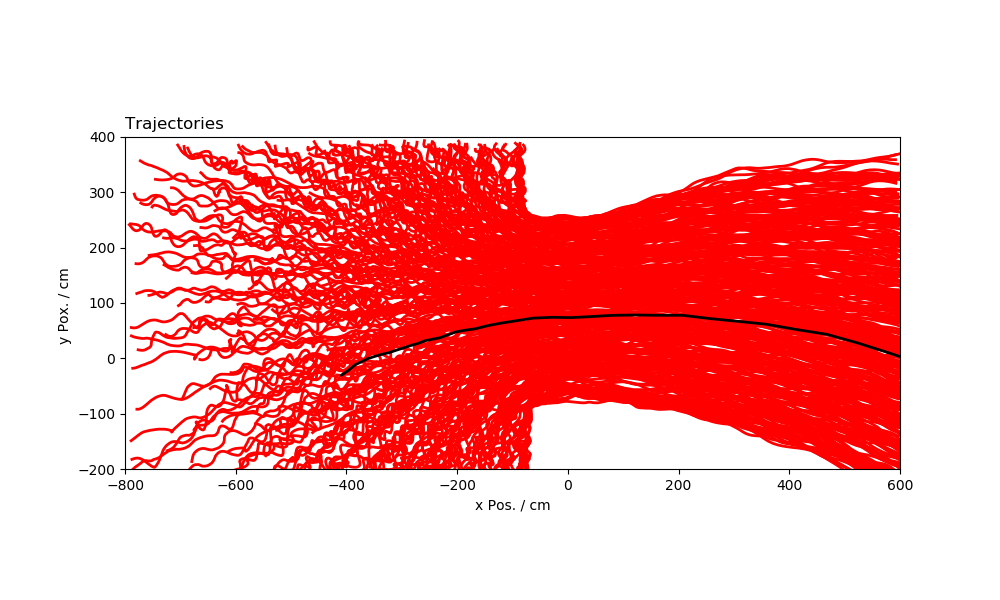

In [53]:
plotTraj(dp,  boundaries=[-800, 600, -200, 400],
         people=None,
         ai=[ 1000+test_person],#test_person,
         legend=False,
         title="Trajectories",
         path="trajectories.png",
         save=False)

<IPython.core.display.Javascript object>


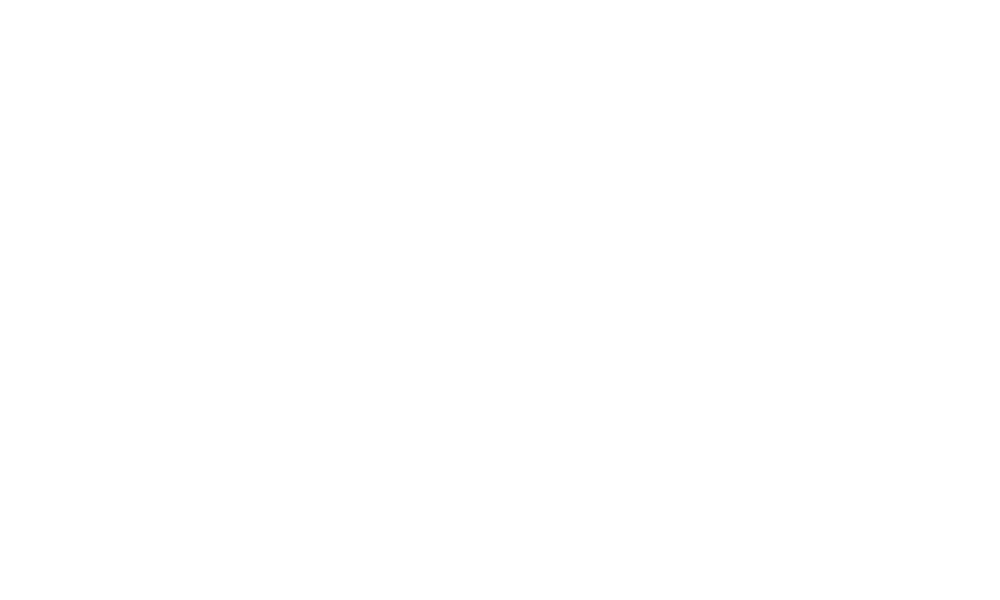

In [56]:
ani = animateLoc(dp, frame_start=frames_o[0], frame_stop=800,ai=[1000+test_person],
             boundaries=[-800, 600, -200, 400], step=param['dataset']['downsample'], fps=16, title="ululululu", save=False,
             path="downsapling_8.gif"
             )
display(ani)

In [ ]:
animatePreview(dp, boundaries=[-600, 600, -250, 150], step=5)

In [ ]:
ani = animateTraj(dp, frame_start=frames_o[0], frame_stop=frames_o[-1], boundaries=[-600, 600, -250, 150], step=1, fps=16, title="Trajectory Animation")
ani

In [83]:
type(param['input_s'])
mask = 0
mask = np.zeros(5)

# Multi agent simulation

In [252]:
agents_id = np.array([10, 13, 16,  20, 22, 26,  30, 35, 40, ]) #120, 160, 200])

agents_id, _ = ds.frame(100)
#agents_id, _ = ds.frame(5)


da = DataLoader(None)

da.copy(ds)
#da.data = da.data[ da.data['f']>200


#agents_id = da.data['p'].unique()[::5]

agents = []

frame_max = 820

for test_person in agents_id:

    frames_o, pos_vel_o =  da.person( test_person, )
    #frames_o, pos_vel_o =  da.grab_roi( *da.person(test_person, ), x_pad=100 )
    
    #get_mean_speed(da, test_person)
    da.remove_person(test_person)

    
    if len(frames_o)<1:
        continue
    
    frame_max = max(frames_o[-1], frame_max)
    
    agents += [Agent(model,
                     FPS=param['dataset']['fps']/param['dataset']['downsample'],
                     pos_vel_0=pos_vel_o[0],
                     frame_0=frames_o[0],
                     truth_with_vel=param['dataset']['truth_with_vel'],
                     device=param['device'],
                     id=1000+test_person )]

#for id in da.data['p'].unique():
#    da.remove_person(id)

print("People in Dataset: ", da.persons)
print("Agents in Dataset: ", len(agents))
print("Frame max: ", frame_max)

sim = Engine(da, agents=agents,
             nn=param['dataset']['neighbors'],
             ret_vel=param['dataset']['ret_vel'],
             nn_vel=param['dataset']['nn_vel'],
             truth_with_vel=param['dataset']['truth_with_vel'],
             mode=param['dataset']['mode'],
             downsample=param['dataset']['downsample'],
             stop_agent=True)

sim.run(100,frame_max, )



dp = DataLoader(None)
dp.copy(sim.ds)

People in Dataset:  169
Agents in Dataset:  179
Frame max:  820
sim from : 100 to 820


 100% |########################################################| Time:  0:00:26


<IPython.core.display.Javascript object>


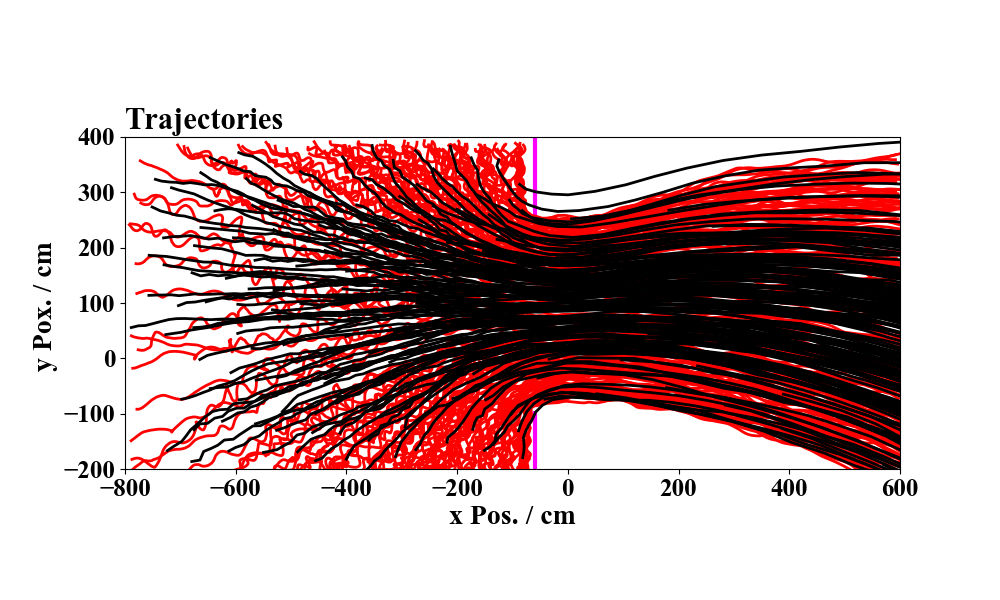

In [233]:
plotTraj(dp,  boundaries=[-800, 600, -200, 400],
         people=None,
         ai=agents_id+1000,
         legend=False,
         wall = True,
         title="Trajectories",
         path="mneck2 - [50,20,50].png",
         save=True)

### Interpolation

In [253]:
#for j in agents_id:
#    get_mean_speed(dp, 1000+j)

dl = DataLoader(None)

dl.copy(dp)

agents_id, _ = ds.frame(100)

pbar = progressbar.ProgressBar(maxval=len(agents_id))
pbar.start()

for (i,agent) in enumerate(agents_id+1000):
    dl.interpolate_person(agent)
    pbar.update(i)
    
pbar.finish()
    


100% (179 of 179) |######################| Elapsed Time: 0:02:10 Time:  0:02:10


<IPython.core.display.Javascript object>


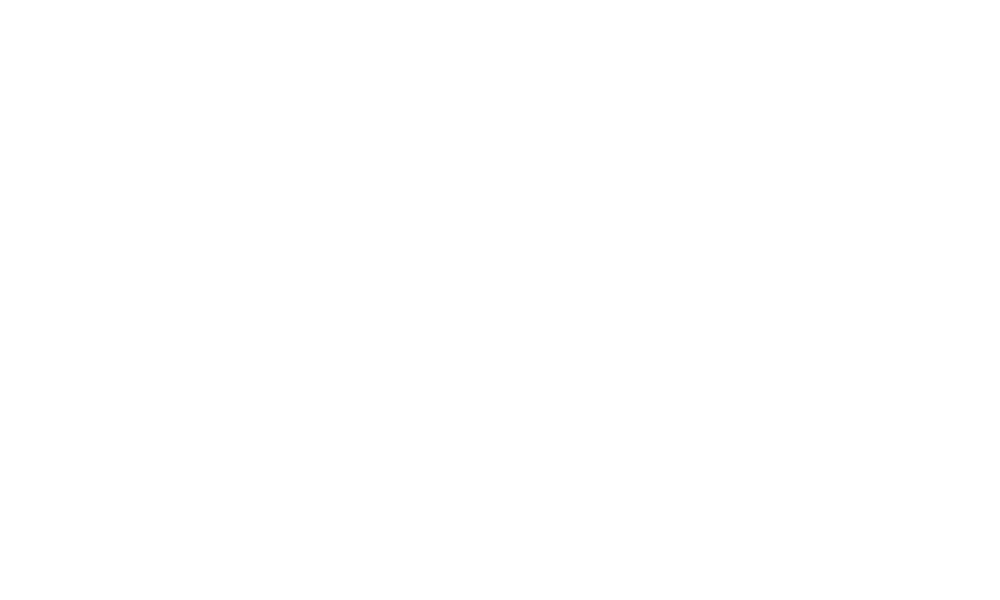

In [254]:
ani = animateLoc(dl, frame_start=100, frame_stop=820,ai=agents_id+1000,
             boundaries=[-800, 600, -200, 400], step=1, fps=16, title="Bottleneck - [50,20,50]", save=True,
             path="downsapling_8_mneck_small.gif", wall=True)
display(ani)

In [255]:
PATH_S = "data/sim/"
#name = "model_UG_downsample_good_"
#name = "model_UG_downsample_good_"
name = "mneck"


#f_name = PATH_M+name+"sweep_vel.h5"
f_name = PATH_S+name+suffix_m

dp.save(f_name)

# Random Placing Agents

<IPython.core.display.Javascript object>


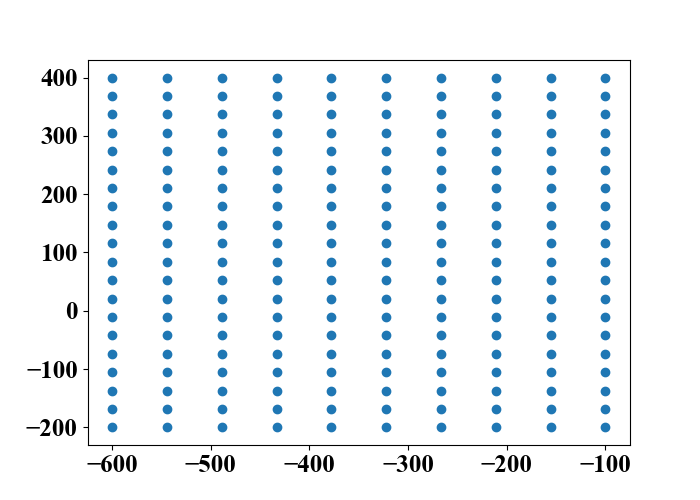

In [242]:
dr = DataLoader(None)
dr.data.columns = ['p', 'f', 'y', 'x', 'z', 'vx', 'vy']
frame0 = 100


#pers, init_val = ds.frame(frame0)

init_val =  np.array([[-400, 100, 30, 0],
                      [-450, 200, 28, -6],
                      [-450, 0, 26, 7],
                      [-425, 150, 29, -2],
                      [-425, 50, 28, 2],
                      [-375, 125, 30, 0],
                      [-375, 75, 29, 0]])


random = False

count = 200

xcount = 10

if random:
    #randomly distribute
    x = np.random.randint(-600, -100, size=(count,)).astype(np.float)
    y = np.random.randint(-200, 400, size=(count,)).astype(np.float)
    vx = np.random.randint(27, 30, size=(count,)).astype(np.float)
    vy = -(y-100)/100

    init_val = np.vstack((x, y, vx, vy)).T
    
else:
    #evenly space
    x = np.linspace(-600, -100, xcount)
    y = np.linspace(-200, 400, int(count/xcount))
    X,Y = np.meshgrid(x, y)
    x = X.ravel()
    y = Y.ravel()
    
    vx = np.random.randint(27, 30, size=(count,)).astype(np.float)
    vy = -(y-100)/100

    init_val = np.vstack((x, y, vx, vy)).T
    
    
pers = np.arange(1,count+1)

frames = np.arange(frame0,700)

for (p_id, init) in zip(pers, init_val):
    pos = init[:2]
    vel = init[2:]
    
    entry = np.concatenate(([p_id], [frame0], np.flip(pos), [0], vel))
    dr.data = dr.data.append(pd.DataFrame([entry], columns=list(ds.data)), ignore_index=True) 
    
dr.data

plt.figure()
plt.scatter(init_val[:,0], init_val[:,1])
plt.show()

People in Dataset:  0
Agents in Dataset:  200
Frame max:  800
sim from : 100 to 800


 100% |########################################################| Time:  0:00:20


<IPython.core.display.Javascript object>


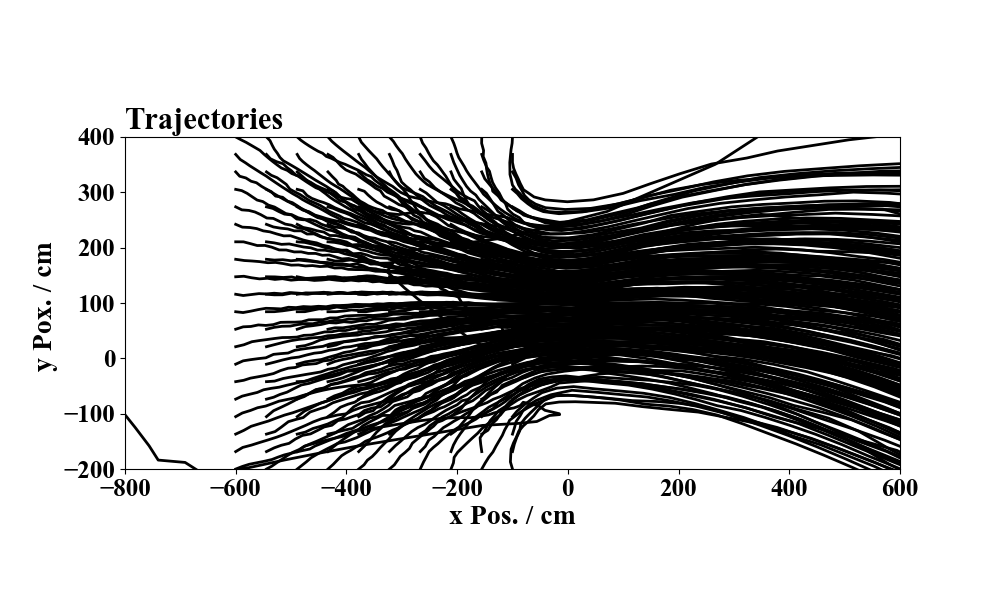

In [243]:
agents = []

frame_max = 800

for test_person in pers:

    frames_o, pos_vel_o =  dr.person( test_person, )
    #frames_o, pos_vel_o =  da.grab_roi( *da.person(test_person, ), x_pad=100 )
    
    #get_mean_speed(da, test_person)
    dr.remove_person(test_person)

    
    if len(frames_o)<1:
        continue
    
    frame_max = max(frames_o[-1], frame_max)
    
    agents += [Agent(model,
                     FPS=param['dataset']['fps']/param['dataset']['downsample'],
                     pos_vel_0=pos_vel_o[0],
                     frame_0=frames_o[0],
                     truth_with_vel=param['dataset']['truth_with_vel'],
                     device=param['device'],
                     id=1000+test_person )]

#for id in da.data['p'].unique():
#    da.remove_person(id)

print("People in Dataset: ", dr.persons)
print("Agents in Dataset: ", len(agents))
print("Frame max: ", frame_max)

sim = Engine(dr, agents=agents,
             nn=param['dataset']['neighbors'],
             ret_vel=param['dataset']['ret_vel'],
             nn_vel=param['dataset']['nn_vel'],
             truth_with_vel=param['dataset']['truth_with_vel'],
             mode=param['dataset']['mode'],
             downsample=param['dataset']['downsample'],
             stop_agent=True)

sim.run(100,frame_max, )



dp = DataLoader(None)
dp.copy(sim.ds)


plotTraj(dp,  boundaries=[-800, 600, -200, 400],
         people=None,
         ai=pers+1000,
         legend=False,
         title="Trajectories",
         path="trajectories.png",
         save=False)

In [246]:
dl = DataLoader(None)

dl.copy(dp)

agents_id, _ = dp.frame(100)

pbar = progressbar.ProgressBar(maxval=len(agents_id))
pbar.start()

for (i,agent) in enumerate(agents_id):
    dl.interpolate_person(agent)
    pbar.update(i)
    
pbar.finish()
    

100% (200 of 200) |######################| Elapsed Time: 0:01:46 Time:  0:01:46


<IPython.core.display.Javascript object>


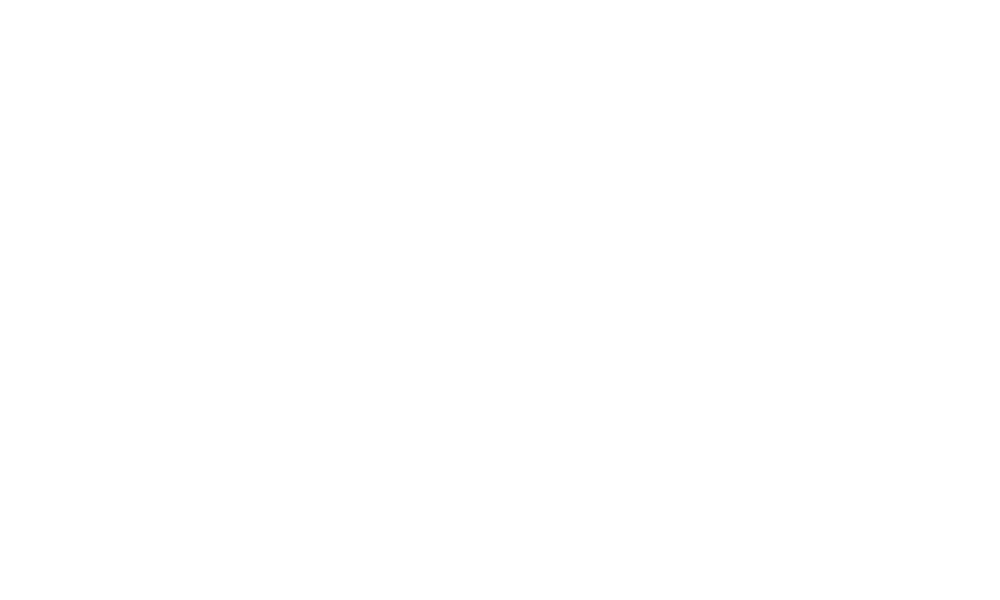

In [251]:
ani = animateLoc(dl, frame_start=100, frame_stop=800,ai=pers+1000,
             boundaries=[-800, 600, -200, 400], step=1, fps=16, title="200 agents - [50,20,50]", save=False,
             path="downsapling_8_multi.gif", wall=True)
display(ani)

In [218]:
PATH_S = "data/sim/"
#name = "model_UG_downsample_good_"
#name = "model_UG_downsample_good_"
name = "mneck_EPFL"


#f_name = PATH_M+name+"sweep_vel.h5"
f_name = PATH_S+name+suffix_m

dp.save(f_name)